In [6]:
%load_ext autoreload
%autoreload 2
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features
import eda

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
is_pickle = False

def elo_load_data(filename=''):
    
    if len(filename):
        df = utils.read_df_pkl(path=f'../input/{filename}*.p')
        return df
    # read pickle
    path_list = glob.glob("../input/*.p")
    for path in path_list:
        filename = re.search(r'/([^/.]*).gz', path).group(1)
        df = utils.read_df_pkl(path=f'../input/{filename}*.p')

if is_pickle:
    import glob
    path_list = glob.glob('../input/*.csv')
    df_list = []
    for i, path in enumerate(path_list):
        df_list.append(pd.read_csv(path))
    
    for df, path in zip(df_list, path_list):
        filename = re.search(r'/([^/.]*).csv', path).group(1)
        utils.to_df_pkl(path='../input/', fname=f"{filename}", df=df)

In [83]:
train = elo_load_data('train')
new = elo_load_data('new_')
# historical = elo_load_data('historical')

100%|██████████| 3/3 [00:00<00:00,  4.19it/s]


In [99]:
display(train.head())
print(train[key].drop_duplicates().shape)
print(train.shape)
display(new.head())
print(new[key].drop_duplicates().shape)

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


(201917,)
(201917, 6)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1.0,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1,9,19
1,Y,C_ID_415bb3a509,140,N,1.0,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1,9,19
2,Y,C_ID_415bb3a509,330,N,1.0,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1,9,14
3,Y,C_ID_415bb3a509,-1,Y,1.0,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NA,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1.0,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NA,-1,29


(287773,)


#### -1はNULL埋めの結果と思われる

In [11]:
for col in new.columns:
    cnt = new[new[col]==-1].shape[0]
    if cnt>0:
        print(col)
        print(cnt)

city_id
99349
installments
55922
merchant_category_id
20
state_id
111745
subsector_id
20


### Cleansing

In [100]:
new = new.where(new['installments']<20, -1)
new['installments'] = new['installments'].replace(-1, np.nan)
new['authorized_flag'] = new['authorized_flag'].replace(-1, 'NA')
new['merchant_id'] =  new['merchant_id'].fillna('NA')
new['category_2'] =  new['category_2'].fillna('NA')
new['category_3'] =  new['category_3'].fillna('NA')

utils.to_df_pkl(df=new, path='../input', fname='new_merchant_transactions')

0it [00:00, ?it/s]

shape: (1963031, 14)


3it [00:01,  1.64it/s]


In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

id_list = [col for col in new.columns if col.count('_id')]
category_list = [col for col in new.columns if col.count('category')]
new_train = train.merge(new, how='inner', on=key)

In [5]:
id_list

['card_id',
 'city_id',
 'merchant_category_id',
 'merchant_id',
 'state_id',
 'subsector_id']

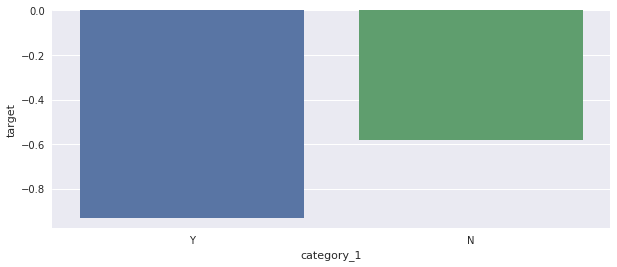

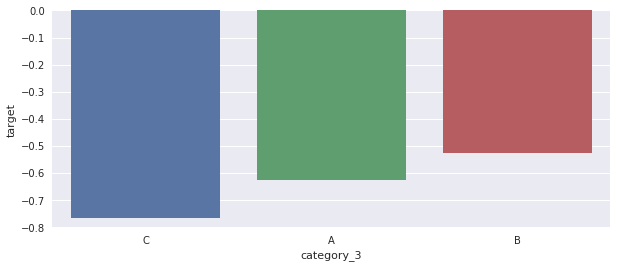

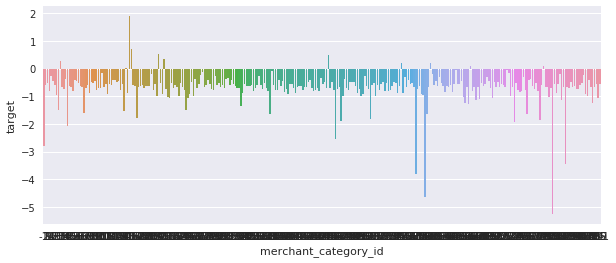

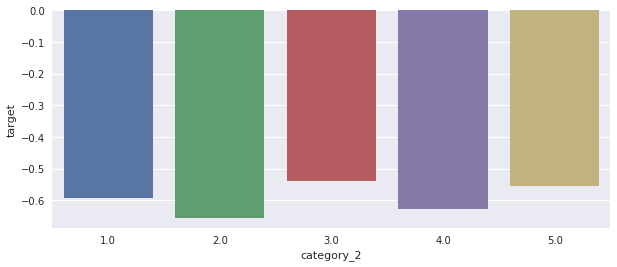

In [35]:
for col in category_list:
    if col in ignore_list:continue
    tmp = new_train.groupby(col)[target].mean().reset_index().sort_values(by=target).reset_index(drop=True)
#     tmp[col] = tmp[col].astype('str')
    plt.figure(figsize=(10, 4))
    sns.barplot(x=tmp[col], y=tmp[target])
    plt.show()
#     sns.lmplot(data=tmp, x=col, y=target, size=10)

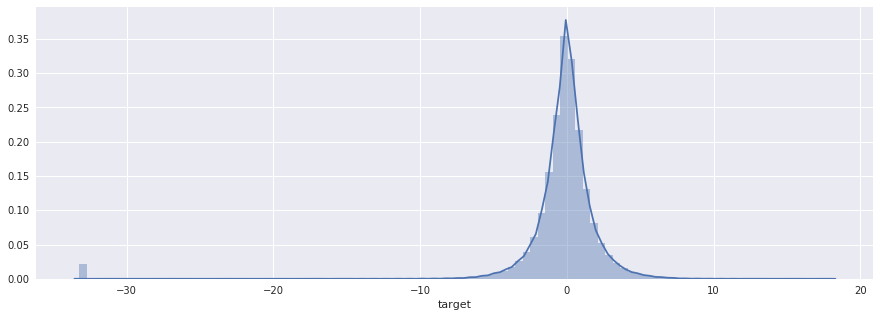

In [28]:
plt.figure(figsize=(15, 5))
sns.distplot(train[target], bins=100)

### 購買回数とLoyalityは相関があると思ったがそうでもない。小さいほど良いのか？

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86]), <a list of 87 Text xticklabel objects>)

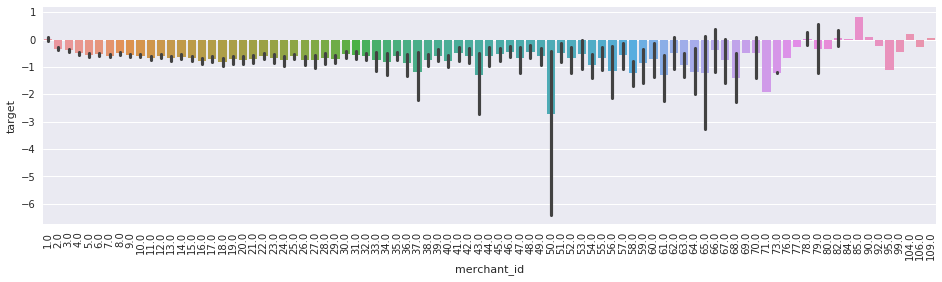

In [45]:
# base = train[[key, target]]
# utils.to_pkl_gzip(obj=base, path='../input/base')
tmp = new_train.groupby(key)['merchant_id'].size()
tmp = base.set_index(key).join(tmp)
plt.figure(figsize=(16, 4))
sns.barplot(data=tmp, x='merchant_id', y=target)
plt.xticks(rotation=90)

### 999という意味不明な外れ値がある

 0      572861
 1      519792
-1       34684
 2       34007
 3       27675
 4        9303
 6        6396
 5        5870
 10       5476
 12       1756
 8         992
 7         532
 9         300
 11         40
 999         1
Name: installments, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

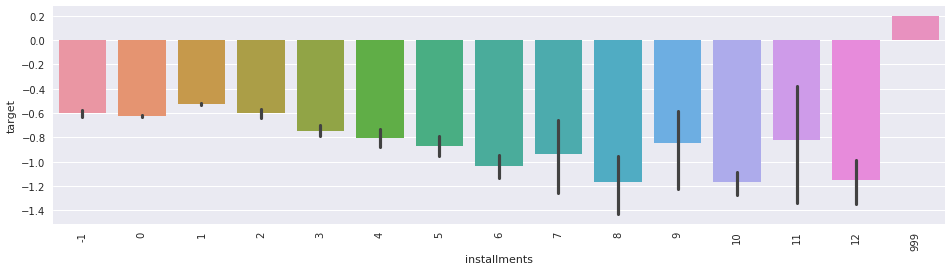

In [50]:
print(new_train['installments'].value_counts().head(30))
plt.figure(figsize=(16, 4))
sns.barplot(data=new_train, x='installments', y=target)
plt.xticks(rotation=90)

#### installmentsの0と1の違いが分からないが、category_1, 3やロイヤリティ平均が異なるので、混ぜないほうがよさげ
#### installments=-1はcategory_3が全てNULL

category_1


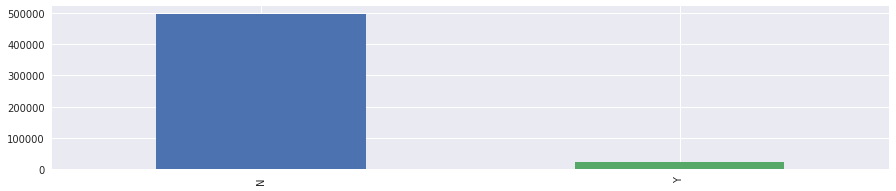

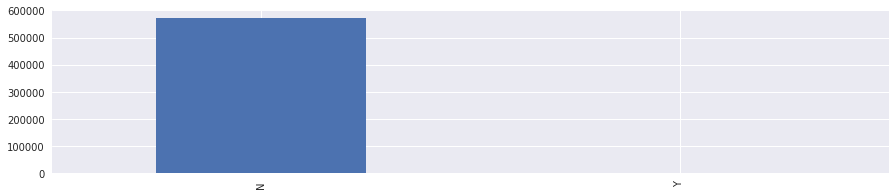

category_3


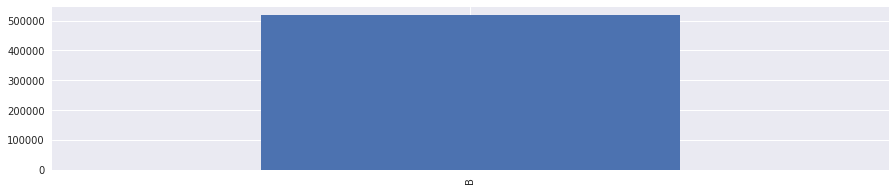

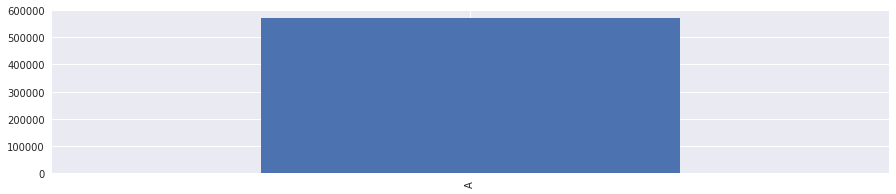

category_2


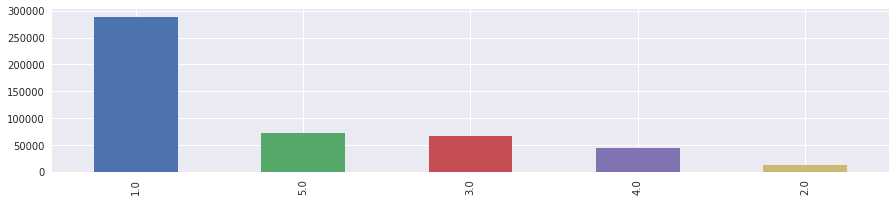

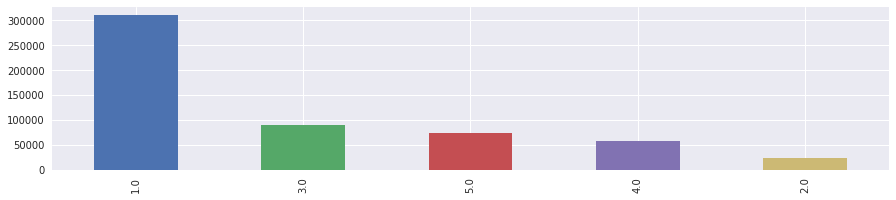

In [60]:
new_train['yyyymm'] = new_train['purchase_date'].map(lambda x: str(x)[:7])
for col in category_list:
    print(col)
    plt.figure(figsize=(15, 3))
    new_train.query("installments==1")[col].value_counts().plot(kind='bar')
    plt.figure(figsize=(15, 3))
    new_train.query("installments==0")[col].value_counts().plot(kind='bar')
    plt.show()

category_1


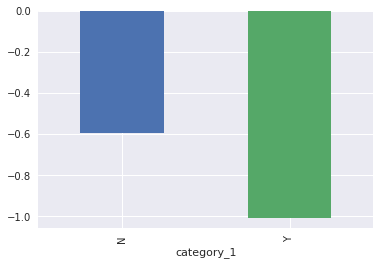

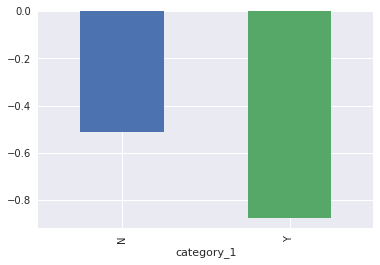

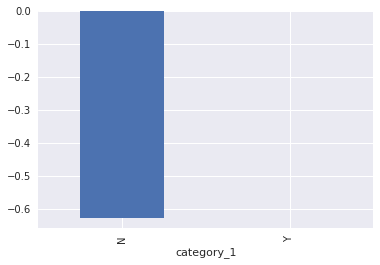

category_3
Series([], Name: category_3, dtype: object)


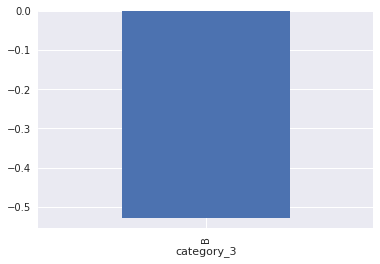

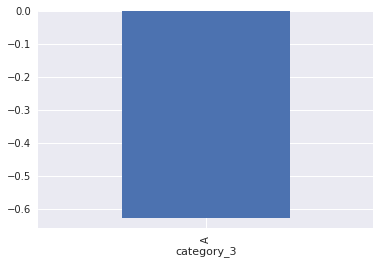

category_2


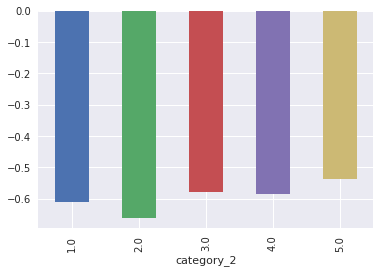

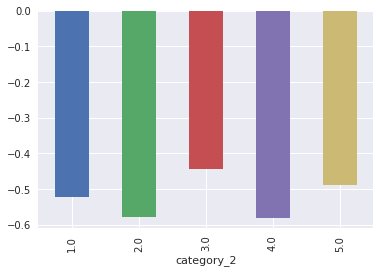

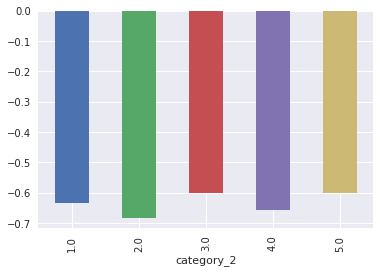

In [73]:
for col in category_list:
    print(col)
    try:
        new_train.query("installments==-1").groupby(col)[target].mean().plot(kind='bar')
        plt.show()
    except TypeError:
        print(new_train.query("installments==-1")[col].dropna())
        pass
    new_train.query("installments==1").groupby(col)[target].mean().plot(kind='bar')
    plt.show()
    new_train.query("installments==0").groupby(col)[target].mean().plot(kind='bar')
    plt.show()

In [78]:
new[['category_3','installments']].drop_duplicates().sort_values(by=['category_3', 'installments'])

,category_3,installments
28,A,0
0,B,1
23,C,2
18,C,3
140,C,4
411,C,5
27,C,6
6739,C,7
1227,C,8
913,C,9
